## Introduction to the Lorenz System

The Lorenz System is a set of three coupled, nonlinear differential equations first studied by Edward Lorenz in 1963. It is one of the earliest and most famous examples of deterministic chaos, the study of systems that are highly sensitive to initial conditions, often referred to as the "butterfly effect." The equations are as follows:

\[
\begin{align*}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x (\rho - z) - y, \\
\frac{dz}{dt} &= x y - \beta z.
\end{align*}
\]

Where:
- \( x, y, \) and \( z \) represent the system states.
- \( \sigma \) is the Prandtl number, representing the rate of heat transfer.
- \( \rho \) is the Rayleigh number, related to the buoyancy force.
- \( \beta \) is a geometric factor.

### Significance in the Study of Chaotic Systems

The Lorenz System was originally derived from a simplified model of atmospheric convection and was one of the first systems to demonstrate the concept of chaos, profoundly influencing the development of chaos theory. Despite its simplicity, the Lorenz system exhibits a range of complex dynamical behaviors depending on the parameter values, including stable points, periodic orbits, and chaotic trajectories. This sensitivity to initial conditions means that even small differences in the starting state of the system can lead to vastly different outcomes, a characteristic that challenges traditional predictions in science.

The study of the Lorenz System helps scientists and mathematicians understand more complex chaotic systems found in meteorology, engineering, economics, and other fields. Its iconic "Lorenz attractor" is a set of chaotic solutions that, when plotted, resemble a butterfly or figure eight, symbolizing the interconnectedness and unpredictability inherent in many natural systems.


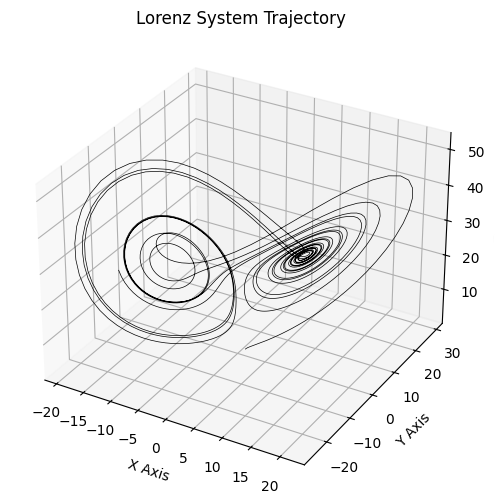

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def lorenz_dynamics(state, dt, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([x + dxdt * dt, y + dydt * dt, z + dzdt * dt])

# This function simulates the Lorenz system over time
def simulate_lorenz(initial_state, dt, steps, sigma=10.0, rho=28.0, beta=8/3):
    states = [initial_state]
    for i in range(1, steps):
        states.append(lorenz_dynamics(states[-1], dt, sigma, rho, beta))
    return np.array(states)

# Initial conditions and parameters for simulation
initial_state = np.array([1.0, 1.0, 1.0])
dt = 0.01
steps = 2000  # Number of steps for the simulation

# Simulate the Lorenz system
lorenz_states = simulate_lorenz(initial_state, dt, steps)

# Plot the Lorenz system
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenz_states[:, 0], lorenz_states[:, 1], lorenz_states[:, 2], color='black', linewidth=0.5)
ax.set_title('Lorenz System Trajectory')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()


## Extended Kalman Filter (EKF) Overview

The Extended Kalman Filter (EKF) is the nonlinear adaptation of the Kalman Filter, designed to handle nonlinearities in system models by linearizing about the current state estimate. It's particularly useful for systems like the Lorenz System, where the EKF can approximate the state trajectory in the presence of chaotic dynamics. By iteratively predicting and correcting the state estimate with new measurements, the EKF helps navigate through the system's unpredictability.


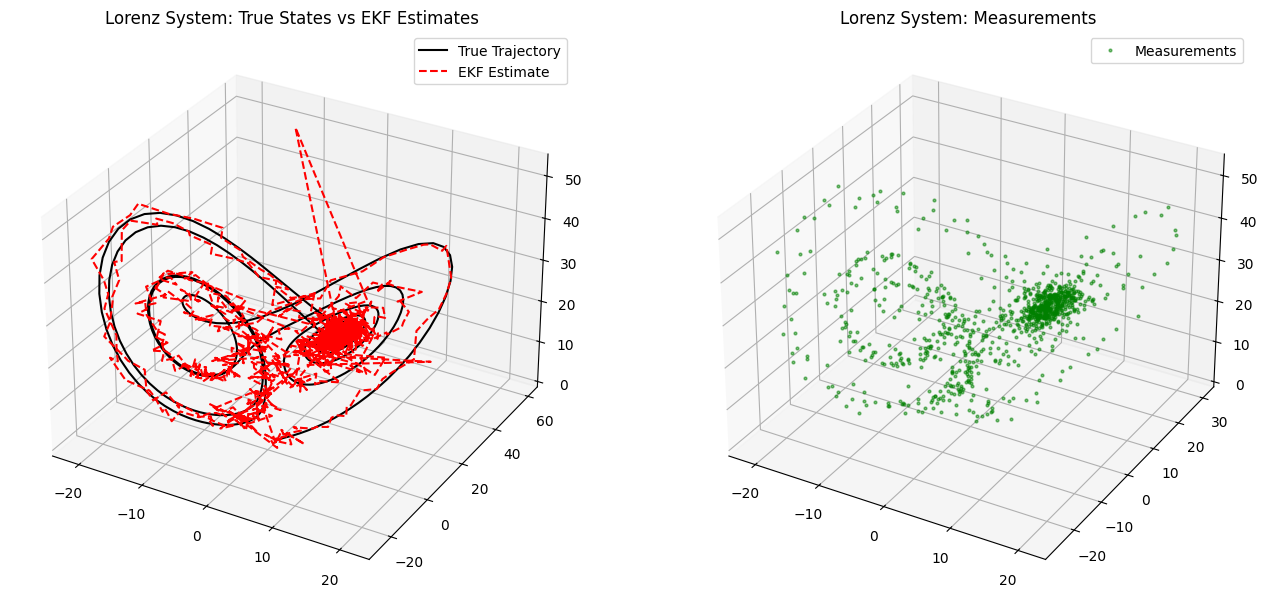

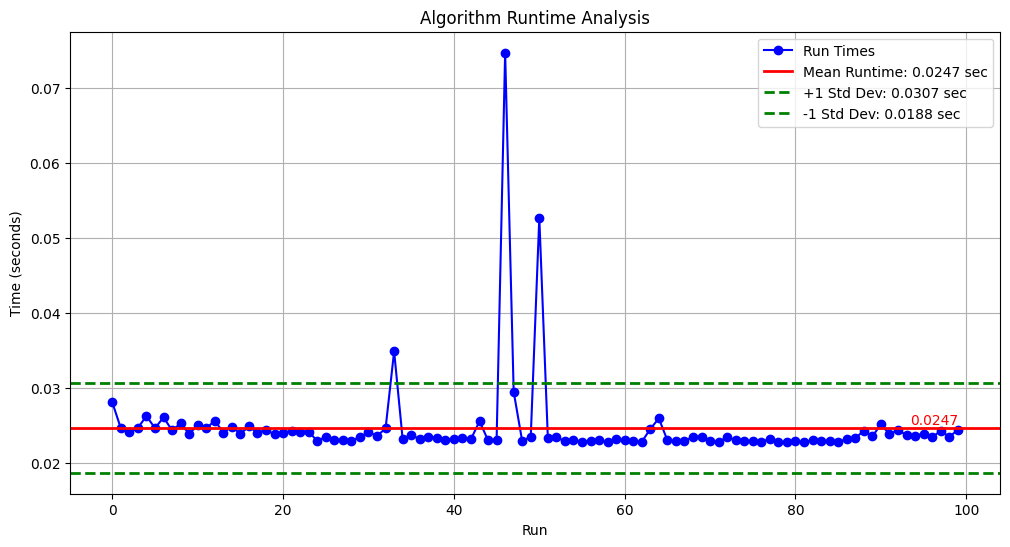

In [128]:
import time

def lorenz_dynamics(state, dt, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([x + dxdt * dt, y + dydt * dt, z + dzdt * dt])


def ekf_predict(x, P, dt, Q, sigma=10.0, rho=28.0, beta=8/3):
    F = np.array([[-sigma, sigma, 0],
                  [rho - x[2], -1, -x[0]],
                  [x[1], x[0], -beta]])
    x_pred = lorenz_dynamics(x, dt, sigma, rho, beta)
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred


def ekf_update(x_pred, P_pred, z, R):
    H = np.eye(3) 
    y = z - H @ x_pred 
    S = H @ P_pred @ H.T + R 
    K = P_pred @ H.T @ np.linalg.inv(S)
    x_upd = x_pred + K @ y
    P_upd = P_pred - K @ S @ K.T
    return x_upd, P_upd


def simulate_lorenz_and_measurements(x0, dt, steps, measurement_noise_std):
    true_states = [x0]
    for _ in range(1, steps):
        true_states.append(lorenz_dynamics(true_states[-1], dt))
    true_states = np.array(true_states)
    measurement_noise = np.random.normal(0, measurement_noise_std, size=(steps, 3))
    measurements = true_states + measurement_noise
    return true_states, measurements


def apply_ekf_to_lorenz(x0, P0, dt, steps, Q, R, measurement_noise_std):
    true_states, measurements = simulate_lorenz_and_measurements(x0, dt, steps, measurement_noise_std)

    start_time = time.time()

    x_ekf = x0
    P_ekf = P0
    ekf_estimates = [x_ekf]
    for z in measurements:
        x_pred, P_pred = ekf_predict(x_ekf, P_ekf, dt, Q)
        x_ekf, P_ekf = ekf_update(x_pred, P_pred, z, R)
        ekf_estimates.append(x_ekf)

    runtime = time.time() - start_time

    ekf_estimates = np.array(ekf_estimates)
    return true_states, measurements, ekf_estimates, runtime


def plot_lorenz_results(true_states, measurements, ekf_estimates):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], 'k-', label='True Trajectory')
    ax.plot(ekf_estimates[:, 0], ekf_estimates[:, 1], ekf_estimates[:, 2], 'r--', label='EKF Estimate')
    ax.set_title("Lorenz System: True States vs EKF Estimates")
    ax.legend()
    ax = fig.add_subplot(122, projection='3d')
    ax.plot(measurements[:, 0], measurements[:, 1], measurements[:, 2], 'go', markersize=2, alpha=0.5, label='Measurements')
    ax.set_title("Lorenz System: Measurements")
    ax.legend()
    plt.show()

def average_runtime_and_plot(func, *args, repetitions=10):
    runtimes = []
    for _ in range(repetitions):
        start_time = time.time()
        func(*args)
        runtimes.append(time.time() - start_time)
    
    average_runtime = sum(runtimes) / repetitions
    std_deviation = np.std(runtimes)
    
    # Plotting the runtimes with statistics
    plt.figure(figsize=(12, 6))
    plt.plot(runtimes, label='Run Times', marker='o', linestyle='-', color='blue')
    plt.axhline(y=average_runtime, color='r', linestyle='-', linewidth=2, label=f'Mean Runtime: {average_runtime:.4f} sec')
    plt.axhline(y=average_runtime + std_deviation, color='g', linestyle='--', linewidth=2, label=f'+1 Std Dev: {average_runtime + std_deviation:.4f} sec')
    plt.axhline(y=average_runtime - std_deviation, color='g', linestyle='--', linewidth=2, label=f'-1 Std Dev: {average_runtime - std_deviation:.4f} sec')
    
    # Annotating the mean line
    plt.text(repetitions - 1, average_runtime, f"{average_runtime:.4f}", color='red', ha='right', va='bottom')
    
    plt.xlabel('Run')
    plt.ylabel('Time (seconds)')
    plt.title('Algorithm Runtime Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return average_runtime, std_deviation

# Initial conditions and parameters
x0 = np.array([1.0, 1.0, 1.0])
P0 = np.eye(3) * 0.1
Q = np.eye(3) * 0.1
R = np.eye(3) * 2.0
dt = 0.01
steps = 1000
measurement_noise_std = 1.0

# Apply EKF
true_states, measurements, ekf_estimates, runtime = apply_ekf_to_lorenz(x0, P0, dt, steps, Q, R, measurement_noise_std)

# Plot the results
plot_lorenz_results(true_states, measurements, ekf_estimates)

# Measure the average runtime of the EKF on the Lorenz system
ekf_average_runtime, ekf_std_deviation = average_runtime_and_plot(apply_ekf_to_lorenz, x0, P0, dt, steps, Q, R, measurement_noise_std, repetitions=100)




# ===================================
## Unscented Kalman Filter (UKF) Overview

The Unscented Kalman Filter (UKF) addresses the limitations of the Extended Kalman Filter (EKF) in handling highly nonlinear systems. By using a deterministic sampling approach, the UKF more accurately captures the mean and covariance of a system's state without the need for linearization. This makes it especially advantageous for systems like the Lorenz attractor, where the EKF's approximations can lead to inaccuracies due to the system's chaotic dynamics.


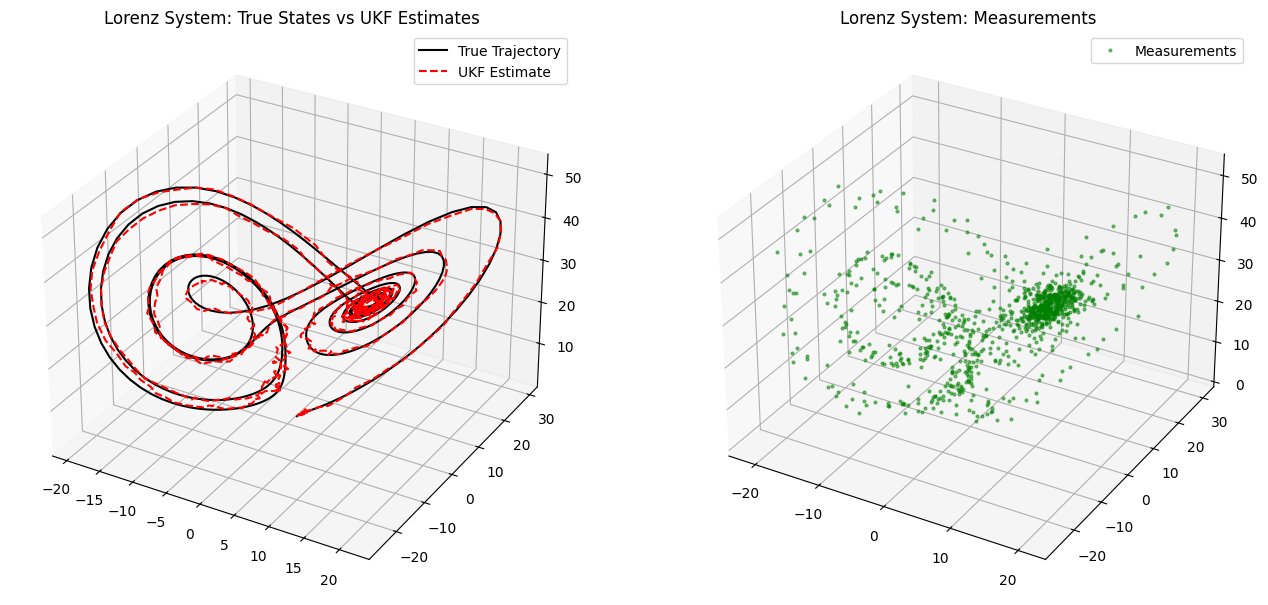

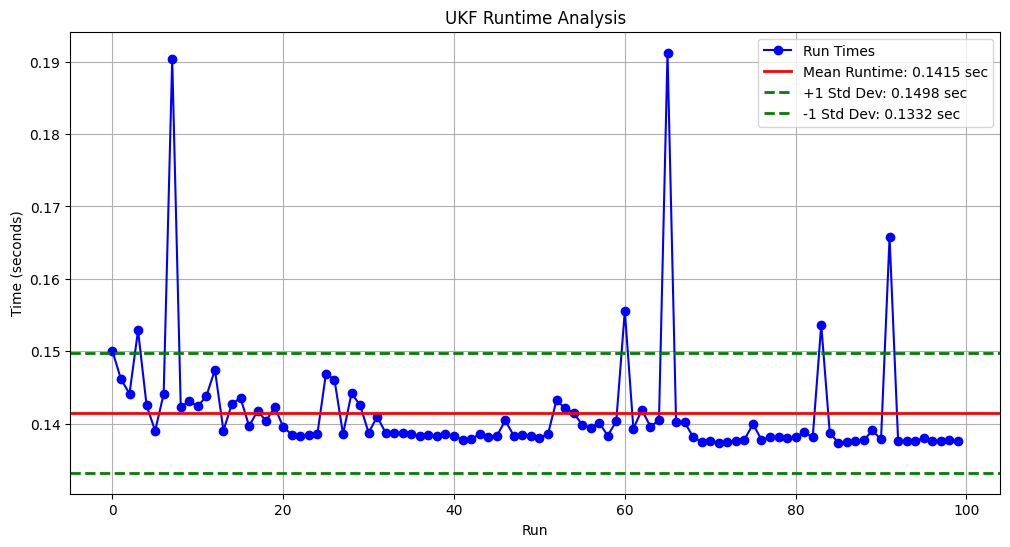

Average Runtime: 0.1415 seconds, Std Deviation: 0.0083 seconds


In [129]:
# Define the Lorenz System and Simulation Function
def lorenz_dynamics(state, dt, sigma=10.0, rho=28.0, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([x + dxdt * dt, y + dydt * dt, z + dzdt * dt])


# Generate SIgma points for the UKF
def generate_sigma_points(x, P, alpha, kappa, beta):
    n = x.size
    lambda_ = alpha**2 * (n + kappa) - n
    sigma_points = np.zeros((2 * n + 1, n))
    wm = np.zeros(2 * n + 1)
    wc = np.zeros(2 * n + 1)
    c = np.sqrt(n + lambda_)
    P_sqrt = np.linalg.cholesky(P)
    
    sigma_points[0] = x
    for i in range(n):
        sigma_points[i + 1] = x + c * P_sqrt[:, i]
        sigma_points[n + i + 1] = x - c * P_sqrt[:, i]
    
    wm.fill(1 / (2 * (n + lambda_)))
    wc.fill(1 / (2 * (n + lambda_)))
    wm[0] = lambda_ / (n + lambda_)
    wc[0] = lambda_ / (n + lambda_) + (1 - alpha**2 + beta)
    
    return sigma_points, wm, wc


# UKF Prediction Step
def ukf_predict(sigma_points, wm, wc, Q, dt):
    n = sigma_points.shape[1]
    predicted_sigma_points = np.array([lorenz_dynamics(sp, dt) for sp in sigma_points])
    x_pred = np.dot(wm, predicted_sigma_points)
    P_pred = np.zeros((n, n))
    for i in range(2 * n + 1):
        diff = predicted_sigma_points[i] - x_pred
        P_pred += wc[i] * np.outer(diff, diff)
    P_pred += Q
    return x_pred, P_pred, predicted_sigma_points


# UKF update step
def ukf_update(x_pred, P_pred, sigma_points_pred, z, R, wm, wc):
    n = x_pred.size
    Z_pred = np.dot(wm, sigma_points_pred)
    Pz = R.copy()
    Pxz = np.zeros((n, n))
    for i in range(2 * n + 1):
        Pz += wc[i] * np.outer(sigma_points_pred[i] - Z_pred, sigma_points_pred[i] - Z_pred)
        Pxz += wc[i] * np.outer(sigma_points_pred[i] - x_pred, sigma_points_pred[i] - Z_pred)
    K = np.dot(Pxz, np.linalg.inv(Pz))
    x_upd = x_pred + np.dot(K, (z - Z_pred))
    P_upd = P_pred - np.dot(K, np.dot(Pz, K.T))
    return x_upd, P_upd


def apply_ukf(x0, P0, dt, steps, Q, R, sigma, rho, beta, alpha, kappa, measurement_noise_std):
    # Initialize the state estimates array
    ukf_estimates = np.zeros((steps, 3))
    ukf_estimates[0] = x0
    
    # Simulate the true system and generate noisy measurements
    true_states = np.zeros((steps, 3))
    true_states[0] = x0
    for i in range(1, steps):
        true_states[i] = lorenz_dynamics(true_states[i-1], dt, sigma, rho, beta)
    
    measurement_noise = np.random.normal(0, measurement_noise_std, true_states.shape)
    measurements = true_states + measurement_noise
    
    # Apply UKF
    x_ukf = x0
    P_ukf = P0
    for i in range(1, steps):
        sigma_points, wm, wc = generate_sigma_points(x_ukf, P_ukf, alpha, kappa, beta)
        x_pred, P_pred, sigma_points_pred = ukf_predict(sigma_points, wm, wc, Q, dt)
        x_ukf, P_ukf = ukf_update(x_pred, P_pred, sigma_points_pred, measurements[i], R, wm, wc)
        ukf_estimates[i] = x_ukf
    
    return true_states, measurements, ukf_estimates

def average_runtime_and_plot(func, args, repetitions=10):
    runtimes = []
    for _ in range(repetitions):
        start_time = time.time()
        func(*args)
        elapsed_time = time.time() - start_time
        runtimes.append(elapsed_time)
    
    average_runtime = np.mean(runtimes)
    std_deviation = np.std(runtimes)
    
    # Plotting the runtimes
    plt.figure(figsize=(12, 6))
    plt.plot(runtimes, label='Run Times', marker='o', linestyle='-', color='blue')
    plt.axhline(y=average_runtime, color='r', linestyle='-', linewidth=2, label=f'Mean Runtime: {average_runtime:.4f} sec')
    plt.axhline(y=average_runtime + std_deviation, color='g', linestyle='--', linewidth=2, label=f'+1 Std Dev: {average_runtime + std_deviation:.4f} sec')
    plt.axhline(y=average_runtime - std_deviation, color='g', linestyle='--', linewidth=2, label=f'-1 Std Dev: {average_runtime - std_deviation:.4f} sec')
    plt.xlabel('Run')
    plt.ylabel('Time (seconds)')
    plt.title('UKF Runtime Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()

    return average_runtime, std_deviation



alpha, kappa, beta = 0.1, 3 - 3, 2
dt, steps = 0.01, 1000
x0, P0 = np.array([1.0, 1.0, 1.0]), np.eye(3) * 0.1
Q, R = np.eye(3) * 0.1, np.eye(3) * 2.0
sigma, rho, beta = 10.0, 28.0, 8/3
measurement_noise_std = np.sqrt(np.diag(R))


fig = plt.figure(figsize=(16, 8))

# True states and UKF estimates
ax = fig.add_subplot(121, projection='3d')
ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], 'k-', label='True Trajectory')
ax.plot(ukf_estimates[:, 0], ukf_estimates[:, 1], ukf_estimates[:, 2], 'r--', label='UKF Estimate')
ax.set_title("Lorenz System: True States vs UKF Estimates")
ax.legend()

# Measurements
ax = fig.add_subplot(122, projection='3d')
ax.plot(measurements[:, 0], measurements[:, 1], measurements[:, 2], 'go', markersize=2, alpha=0.5, label='Measurements')
ax.set_title("Lorenz System: Measurements")
ax.legend()

plt.show()


# Prepare arguments for the runtime analysis function
ukf_args = (x0, P0, dt, steps, Q, R, sigma, rho, beta, alpha, kappa, measurement_noise_std)

# Measure and plot the average runtime
average_runtime, std_deviation = average_runtime_and_plot(apply_ukf, ukf_args, repetitions=100)

print(f"Average Runtime: {average_runtime:.4f} seconds, Std Deviation: {std_deviation:.4f} seconds")


